<script type="text/x-mathjax-config">

MathJax.Hub.Config({

  tex2jax: {inlineMath: [['$','$'], ['\\(','\\)']]}

});

</script>

<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/latest.js?config=TeX-MML-AM_CHTML' async></script>

## Project2 이진 분류기 모델 활용

### 1. 개요

이번 프로젝트에서는 앞서 구현한 이진 분류기 모델을 이용하여 간단한 형태의 논리 게이트를 구현하고자 한다.

이진 분류기 모델은 projectfiles.binclassifier.py에 정의되어있는 세가지 모델들 중 하나를 이용한다. AdalineGD 모델이 앞선 프로젝트에서 구현한 아달린 모델과 동일한 것이다.

또한 데이터의 분석과 시각화를 위해서 미리 정의해둔 플로팅 함수들을 사용한다. 해당 함수들은 projectfiles.analyzer.graphics에 정의되어있다.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from projectfiles.analyzer.graphics import plot_decision_regions
from projectfiles.binclassifier import AdalineGD, AdalineSGD, LogisticRegression

### 2. AdalineGD 모델과 확률

앞선 프로젝트에서 구현한 이진 분류기 모델의 본질적인 의미는 다음과 같다:

<blockquote>어떤 데이터가 특정 데이터 레이블로 구분될 수 있는지를 판별한다.</blockquote>

따라서 이상적인 이진 분류기 모델은 어떤 데이터가 특정 레이블로 구분될 수 있을 때 1을 리턴하고, 아니면 0을 리턴한다. 이때 1을 양성 클래스 레이블(positive class label), 0을 음성 클래스 레이블(negative class label)로 정의한다. 물론 이진 분류기의 판단이 항상 맞는 것은 아니다. 단지 이진 분류기는 내부적인 계산과정을 통해 특정 데이터의 레이블을 짐작할 뿐이며, 예측된 레이블이 항상 맞는다는 보장은 그 어디에도 없다.

하지만 이는 사람도 마찬가지다. 사람들은 살아가면서 수많은 예측을 하지만 그 예측이 빗나가는 경우는 굉장히 많다. 따라서 우리의 이진 분류기 모델이 항상 정답만을 리턴할 것이라 가정하는것은 옳지 않다. 이런 이유로 인해 많은 데이터 과학 분야에서는 확률을 도입하여 이러한 불확실성을 수치화한다.

다시 본래의 주제로 돌아와서 이상적인 이진 분류기는 어떠한 데이터를 양성 클래스와 음성 클래스로 구분한다. 하지만 이는 앞서 말했듯, 이진 분류기가 내부적인 계산과정을 통해 더 높은 확률에 속하는 레이블을 데이터에 할당하는 것으로 볼 수 있다. 그렇다면 이진 분류기는 어떤 데이터가 양성 클래스일 확률을 어떻게 계산하는 것일까? 앞서 구현한 AdalineGD 모델에서 클래스 레이블 $label$은 다음 수식에 의해 결정된다.

$$\begin{aligned}
input &= (data * weight[1:]) + weight[0] \\ \\
output &= activation(input) = input \\ \\
label &= \left\{\begin{matrix}
1 & \text{if } output > 0.5\\ 
0 & \text{otherwise}
\end{matrix}\right. 
\end{aligned}$$

따라서 우리는 이와 같은 결론을 내릴 수 있다.

<blockquote>AdalineGD 모델은 출력($output$)을 확률로서 사용한다.</blockquote>

### 3. 로지스틱 시그모이드 함수를 이용한 확률

앞서 확인했듯 분류기 모델의 출력은 클래스 레이블 구분에 이용되는 확률적 요소로서 정의된 것이다. 그런데 AdalineGD 모델에서의 출력은 엄밀히 따졌을 때 확률적인 요소가 아니다. 따라서 이진 분류기 모델의 출력을 확률적 함수의 형태로 변환하기 위한 새로운 활성화 함수(activation function)로 로지스틱 시그모이드 함수(logistic sigmoid function)를 제시한다.

AdalineGD 모델에서 활성화 함수는 항등 함수(identity function)였다. 따라서 모델의 출력은 사실상 모델 내부적으로 정의한 $input$(코드에서는 net_input)과 동일한 것이다. 하지만 앞서 우리가 확인한 것과는 다르게 $input$은 어떠한 확률적 의미도 갖지 못한다. 왜냐하면 $input$은 기본적으로 0과 1사이의 값으로 정의되지 않기 때문이다. 이는 사실 굉장히 중요한 문제이다. 만약 학습이 진행되면서 가중치 벡터가 발산하면 $input$의 크기는 무한히 커지거나 작아질 수 있는데, 이렇게 발산하는(혹은 발산할 가능성이 있는) 값을 확률적으로 해석하는 것은 굉장히 위험하다.

따라서 무한히 작아지거나 커지는 값을 확률적으로 재해석할 수 있는 새로운 수단으로 오즈(odds)라는 개념을 사용한다. 임의의 사건에 대한 확률 $P$에 대해 오즈는 실패 확률에 대한 성공 확률의 비율로, 다음과 같이 정의된다.

$$odds=\frac{P}{1-P}$$

이때 확률 $P$는 다음과 같다.

$$P=\frac{odds}{1+odds}$$

위 수식을 살펴보면 확률이 0과 1 사이일 때 오즈는 발산함을 알 수 있다. 따라서 $input$을 이용해 오즈를 정의함으로서 해당 데이터가 양성 클래스로 분류될 확률 $P$를 얻을 수 있다. 

하지만 오즈도 완벽한 해결책은 아니다. 왜냐하면 이진 분류기는 $P$가 0.5일때를 기준으로 데이터를 구분하는데, $P$가 0.5일 때 오즈가 1로 정의되기 때문이다. 따라서 $input$을 기준으로 생각하면 $input$이 1일 때를 기준으로 데이터의 구분이 이루어지게 된다. 하지만 이는 $input$의 특성상 썩 바람직한 것은 아니다. 왜냐하면 $input$이 1에 편향되기 때문이다.

따라서 오즈를 로그 스케일로 변환한 로짓(logit)이라는 개념을 이용한다. 로짓은 다음과 같이 정의된다.

$$logit=ln(odds)=ln(\frac{P}{1-P})$$

이때 확률 $P$는 다음과 같다.

$$P=\frac{1}{1+e^{-logit}}=sigmoid(logit)$$

로짓을 이용하면 $P$가 0.5일 때 로짓이 0이 되므로 앞서 확인한 편향과 관련된 문제점이 사라지게 된다. 따라서 $input$과 $output$을 다음과 같이 재정의한다.

$$ \begin{aligned}
input &= logit = (data * weight[1:]) + weight[0] \\ \\
output &= P = sigmoid(input) \\ \\
label &= \left\{\begin{matrix}
1 & \text{if } output > 0.5\\ 
0 & \text{otherwise}
\end{matrix}\right.
\end{aligned}$$

위의 수식에서 $sigmoid()$ 함수는 활성화 함수로 아래와 같이 나타난다. 

Text(0.5, 1.0, 'Logistic Sigmoid Function')

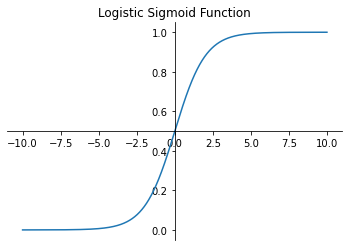

In [2]:
def sigmoid(x):
    return 1. / (1. + np.exp(-x))

x = np.arange(-10, 10, 0.01)
y = sigmoid(x)

fig = plt.figure()

ax = fig.add_subplot()
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot(x, y)
ax.set_title('Logistic Sigmoid Function')

이처럼 시그모이드 함수를 활성화 함수로 사용하는 모델을 로지스틱 회귀(Logistic Regression) 모델이라 한다. 로지스틱 회귀와 아달린 모델은 유사한 점이 굉장히 많으므로 로지스틱 회귀 모델의 구현은 생략한다. projectfiles.binclassifier에 있는 LogisticRegression이 로지스텍 회귀 모델이니 한번 확인해보자. 한 가지 차이점은 비용함수로 AdalineGD 모델에서 사용한 SSE(Sum of Squared Error, 제곱 오차합) 대신 CEE(Cross Entropy Error, 교차 엔트로피 오차)가 사용되었다. 이는 단순히 구현의 용이성을 위한 것이니 크게 신경쓸 필요는 없다.

### Problem: 논리 게이트 구현하기

앞서 소개한 이진 분류기를 이용하여 논리 게이트를 구현할 수 있다. 물론 논리 게이트를 시뮬레이션 하기 위한 더 효율적인 방법들은 얼마든지 많다. 그럼에도 이진 분류기를 이용하여 논리 게이트를 구현함으로써, 기계에게 논리적인 추론을 학습시킬 수 있음을 실증적으로 증명하고, 나아가 복잡하게 결정경계가 결정되는 문제들로 논의를 확장하고자 한다.

논리 게이트는 0과 1로 이루어진 부울(boolean) 대수를 연산하기 위한 장치이다. 논리 게이트들에는 여러가지가 있지만 그 중에서 AND 게이트를 머신러닝을 이용해 구현하고자 한다. AND 게이트는 총 두 개의 입력과 하나의 출력 단자를 가진다. 각 단자에 입력 혹은 출력될 수 있는 값은 0과 1로 한정되며 다음과 같은 진리표(truth table)에 의해 정의된다.

| 입력 | 출력
|-:- |-:-
| 0 0 | 0
| 0 1 | 0
| 1 0 | 0
| 1 1 | 1

따라서 학습이 가능한 데이터는 위의 네 가지이다. 위 진리표를 바탕으로 AND 게이트를 구현하여라.

이름은 ANDGate로 하라.

binclassifier 안에 정의된 모델을 사용하라.

학습에 사용할 데이터는 data, 레이블은 and_label로 정의하라.

In [15]:
data = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

and_label = np.array([0, 0, 0, 1])

ANDGate = AdalineGD(eta=0.01, n_iter=10, random_state=1)
ANDGate.fit(data, and_label, shuffle=True)

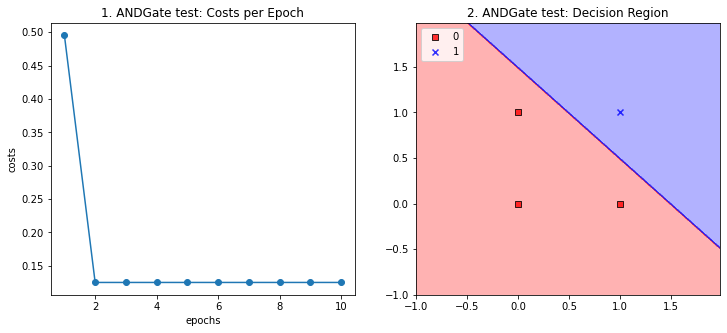

In [17]:
result_and = plt.figure(figsize=(12, 5))
ax1 = result_and.add_subplot(1, 2, 1)
ax2 = result_and.add_subplot(1, 2, 2)

ANDGate.plot_costs(ax=ax1, resolution=1000)
ax1.set_title('1. ANDGate test: Costs per Epoch')
ax1.set_xlabel('epochs')
ax1.set_ylabel('costs')

plot_decision_regions(data, and_label, ANDGate, resolution=0.02, names='default', ax=ax2)
ax2.set_title('2. ANDGate test: Decision Region')
ax2.legend(loc='upper left')

plt.show()

OR 게이트 또한 총 두 개의 입력과 하나의 출력 단자를 가진다. 각 단자에 입력 혹은 출력될 수 있는 값은 0과 1로 한정되며 다음과 같은 진리표(truth table)에 의해 정의된다.

| 입력 | 출력
|-:- |-:-
| 0 0 | 0
| 0 1 | 1
| 1 0 | 1
| 1 1 | 1

따라서 학습이 가능한 데이터는 위의 네 가지이다. 위 진리표를 바탕으로 OR 게이트를 구현하여라.

이름은 ORGate로 하라.

binclassifier 안에 정의된 모델을 사용하라.

학습에 사용할 데이터는 data, 레이블은 or_label로 정의하라.

In [5]:
data = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

or_label = np.array([0, 1, 1, 1])

ORGate = LogisticRegression(eta=0.01, n_iter=1000, random_state=1)
ORGate.fit(data, or_label, shuffle=True)

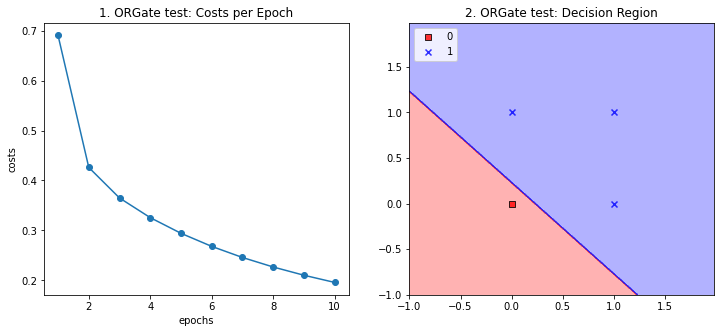

In [6]:
result_or = plt.figure(figsize=(12, 5))
ax1 = result_or.add_subplot(1, 2, 1)
ax2 = result_or.add_subplot(1, 2, 2)

ORGate.plot_costs(ax=ax1, resolution=100)
ax1.set_title('1. ORGate test: Costs per Epoch')
ax1.set_xlabel('epochs')
ax1.set_ylabel('costs')

plot_decision_regions(data, or_label, ORGate, resolution=0.02, names='default', ax=ax2)
ax2.set_title('2. ORGate test: Decision Region')
ax2.legend(loc='upper left')

plt.show()